In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Opsional: Jika Anda menggunakan Google Colab, jalankan baris ini untuk mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path folder tempat dataset Anda saat ini (sesuaikan dengan lokasi di laptop/colab Anda)
# Pastikan folder ini berisi 6 sub-folder (freshapples, rottenapples, dll)
source_path = '/content/drive/MyDrive/UAP ML/Dataset UAP'

# Path folder tujuan untuk proyek UAP Anda
base_dir = 'dataset_uap'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Membuat struktur folder baru
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [ ]:
# Ambil daftar nama kelas dari folder sumber
classes = os.listdir(source_path)

# Rasio pembagian
train_ratio = 0.8

for class_name in classes:
    # Buat sub-folder kelas di dalam train dan val
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Ambil semua file gambar dalam kelas tersebut
    src_class_path = os.path.join(source_path, class_name)
    all_images = [f for f in os.listdir(src_class_path) if os.path.isfile(os.path.join(src_class_path, f))]

    # Acak urutan gambar (shuffling) agar pembagian data objektif
    random.shuffle(all_images)

    # Tentukan titik potong berdasarkan rasio
    split_point = int(len(all_images) * train_ratio)

    train_images = all_images[:split_point]
    val_images = all_images[split_point:]

    # Proses pemindahan/penyalinan file ke folder baru
    for img in train_images:
        shutil.copy(os.path.join(src_class_path, img), os.path.join(train_dir, class_name, img))

    for img in val_images:
        shutil.copy(os.path.join(src_class_path, img), os.path.join(val_dir, class_name, img))

print("Proses Splitting Selesai!")

Proses Splitting Selesai!


In [ ]:
def count_files(directory):
    for root, dirs, files in os.walk(directory):
        if root != directory:
            print(f"{os.path.basename(root)}: {len(files)} gambar")

print("--- JUMLAH DATA TRAINING ---")
count_files(train_dir)
print("\n--- JUMLAH DATA VALIDATION ---")
count_files(val_dir)

--- JUMLAH DATA TRAINING ---
freshoranges: 1172 gambar
rottenbanana: 1783 gambar
freshbanana: 1264 gambar
rottenoranges: 1531 gambar
freshapples: 1354 gambar
rottenapples: 1873 gambar

--- JUMLAH DATA VALIDATION ---
freshoranges: 294 gambar
rottenbanana: 445 gambar
freshbanana: 317 gambar
rottenoranges: 574 gambar
freshapples: 339 gambar
rottenapples: 469 gambar


Menampilkan Sampel Gambar dari Dataset...


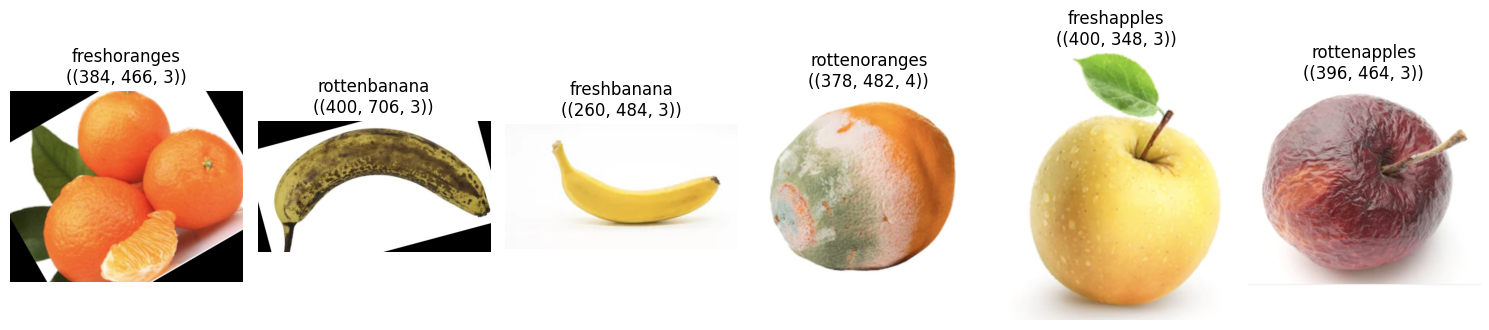

In [ ]:
import matplotlib.image as mpimg

def show_dataset_samples(directory):
    # Ambil semua kelas
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    plt.figure(figsize=(15, 5))
    for i, class_name in enumerate(classes):
        # Ambil list file di dalam folder kelas
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)

        # Pilih satu gambar secara acak
        random_img = random.choice(images)
        img_path = os.path.join(class_path, random_img)

        # Baca dan tampilkan gambar
        img = mpimg.imread(img_path)
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.title(f"{class_name}\n({img.shape})") # Menampilkan nama kelas & resolusi
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk melihat sampel di folder training
print("Menampilkan Sampel Gambar dari Dataset...")
show_dataset_samples(train_dir)

# Model Base (CNN)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameter Utama
TARGET_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 30 # Early stopping akan menghentikannya jika sudah optimal

# Generator (Hanya Rescale)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Callback Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

Found 8977 images belonging to 6 classes.
Found 2438 images belonging to 6 classes.


In [ ]:
model_base = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])
model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_base.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_base = model_base.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)
model_base.save('model_base.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 62s 198ms/step - accuracy: 0.5541 - loss: 1.1556 - val_accuracy: 0.8675 - val_loss: 0.3366
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.8730 - loss: 0.3592 - val_accuracy: 0.8544 - val_loss: 0.4104
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 171ms/step - accuracy: 0.9049 - loss: 0.2713 - val_accuracy: 0.9159 - val_loss: 0.2169
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 47s 167ms/step - accuracy: 0.9215 - loss: 0.2174 - val_accuracy: 0.9495 - val_loss: 0.1401
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - accuracy: 0.9357 - loss: 0.1857 - val_accuracy: 0.9504 - val_loss: 0.1365
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 165ms/step - accuracy: 0.9468 - loss: 0.1554 - val_accuracy: 0.9512 - val_loss: 0.1401
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 47s 166ms/step - accuracy: 0.9481 - loss: 0.1505 - val_accuracy: 0.9684 - val_loss: 0.0966
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 165ms/step - accuracy: 0.9625 - loss: 0

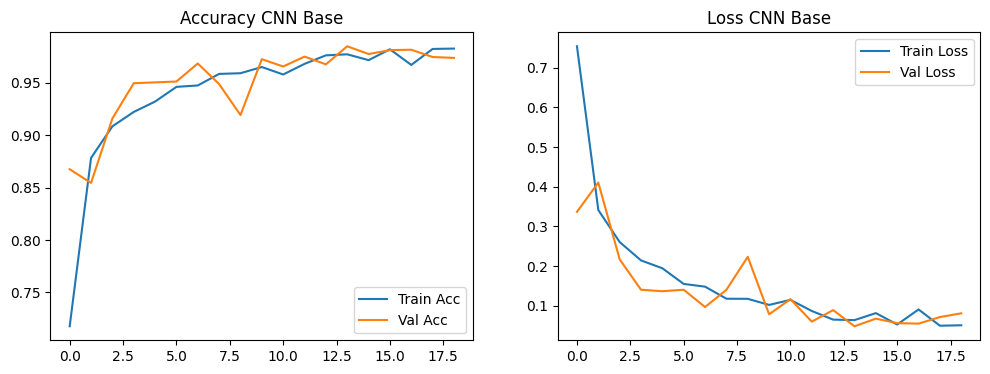

In [ ]:
def plot_result(history, name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy {name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss {name}')
    plt.legend()
    plt.show()

plot_result(history_base, "CNN Base")

# Model 2 - MobileNetV2 (Pretrained 1)

In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_mobilenet.trainable = False # Freeze layers

x = GlobalAveragePooling2D()(base_mobilenet.output)
x = Dense(128, activation='relu')(x)
out_pre1 = Dense(6, activation='softmax')(x)

model_pre1 = Model(inputs=base_mobilenet.input, outputs=out_pre1)
model_pre1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/tmp/ipython-input-4250171918.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [ ]:
history_pre1 = model_pre1.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)
model_pre1.save('model_mobilenet.h5')

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 90s 259ms/step - accuracy: 0.8663 - loss: 0.3968 - val_accuracy: 0.9815 - val_loss: 0.0589
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 45s 161ms/step - accuracy: 0.9894 - loss: 0.0336 - val_accuracy: 0.9852 - val_loss: 0.0404
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 164ms/step - accuracy: 0.9941 - loss: 0.0206 - val_accuracy: 0.9865 - val_loss: 0.0347
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 45s 160ms/step - accuracy: 0.9940 - loss: 0.0182 - val_accuracy: 0.9963 - val_loss: 0.0152
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - accuracy: 0.9969 - loss: 0.0083 - val_accuracy: 0.9959 - val_loss: 0.0116
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 165ms/step - accuracy: 0.9984 - loss: 0.0068 - val_accuracy: 0.9959 - val_loss: 0.0096
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - accuracy: 0.9956 - loss: 0.0111 - val_accuracy: 0.9975 - val_loss: 0.0092
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 47s 166ms/step - accuracy: 0.9993 - loss: 0

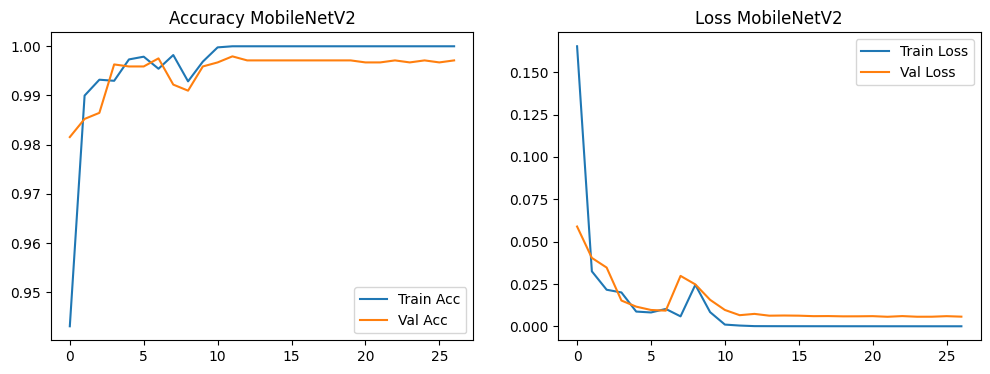

In [ ]:
plot_result(history_pre1, "MobileNetV2")

# Model 3 - VGG16 (Pretrained 2)

In [ ]:
from tensorflow.keras.applications import VGG16

base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_vgg.trainable = False

y = GlobalAveragePooling2D()(base_vgg.output)
y = Dense(128, activation='relu')(y)
out_pre2 = Dense(6, activation='softmax')(y)

model_pre2 = Model(inputs=base_vgg.input, outputs=out_pre2)
model_pre2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
history_pre2 = model_pre2.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)
model_pre2.save('model_vgg16.h5')

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 70s 220ms/step - accuracy: 0.6387 - loss: 1.0269 - val_accuracy: 0.9016 - val_loss: 0.3278
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 54s 192ms/step - accuracy: 0.9056 - loss: 0.2930 - val_accuracy: 0.9290 - val_loss: 0.2144
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 53s 189ms/step - accuracy: 0.9337 - loss: 0.2100 - val_accuracy: 0.9479 - val_loss: 0.1697
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 52s 184ms/step - accuracy: 0.9529 - loss: 0.1546 - val_accuracy: 0.9553 - val_loss: 0.1410
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 53s 187ms/step - accuracy: 0.9615 - loss: 0.1233 - val_accuracy: 0.9578 - val_loss: 0.1319
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 52s 187ms/step - accuracy: 0.9612 - loss: 0.1144 - val_accuracy: 0.9619 - val_loss: 0.1139
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 52s 186ms/step - accuracy: 0.9687 - loss: 0.0975 - val_accuracy: 0.9606 - val_loss: 0.1089
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.9709 - loss: 0

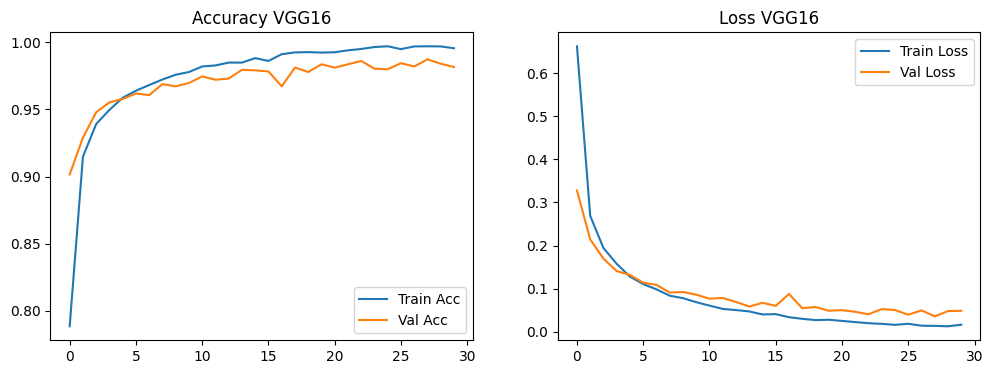

In [ ]:
plot_result(history_pre2, "VGG16")

Found 10901 images belonging to 6 classes.

📊 EVALUASI MODEL: CNN Base (Non-Pretrained)
10901/10901 ━━━━━━━━━━━━━━━━━━━━ 114s 10ms/step

Classification Report:
               precision    recall  f1-score   support

  freshapples       0.00      0.00      0.00      1693
  freshbanana       0.16      0.66      0.26      1581
 freshoranges       0.15      0.32      0.20      1466
 rottenapples       0.00      0.00      0.00      2342
 rottenbanana       0.55      0.05      0.09      2224
rottenoranges       0.12      0.07      0.09      1595

     accuracy                           0.16     10901
    macro avg       0.16      0.18      0.11     10901
 weighted avg       0.17      0.16      0.10     10901



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


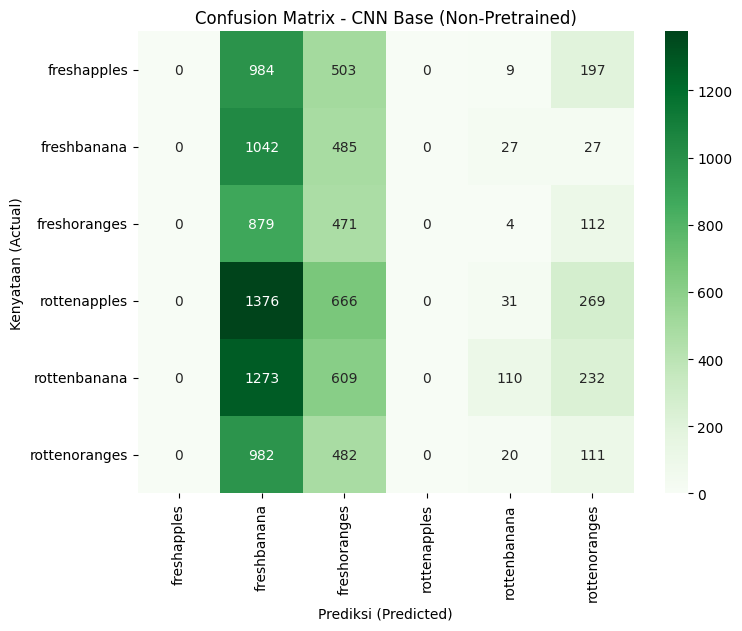


📊 EVALUASI MODEL: MobileNetV2 (Pretrained 1)
10901/10901 ━━━━━━━━━━━━━━━━━━━━ 128s 11ms/step

Classification Report:
               precision    recall  f1-score   support

  freshapples       1.00      1.00      1.00      1693
  freshbanana       1.00      1.00      1.00      1581
 freshoranges       1.00      1.00      1.00      1466
 rottenapples       1.00      1.00      1.00      2342
 rottenbanana       1.00      1.00      1.00      2224
rottenoranges       1.00      1.00      1.00      1595

     accuracy                           1.00     10901
    macro avg       1.00      1.00      1.00     10901
 weighted avg       1.00      1.00      1.00     10901



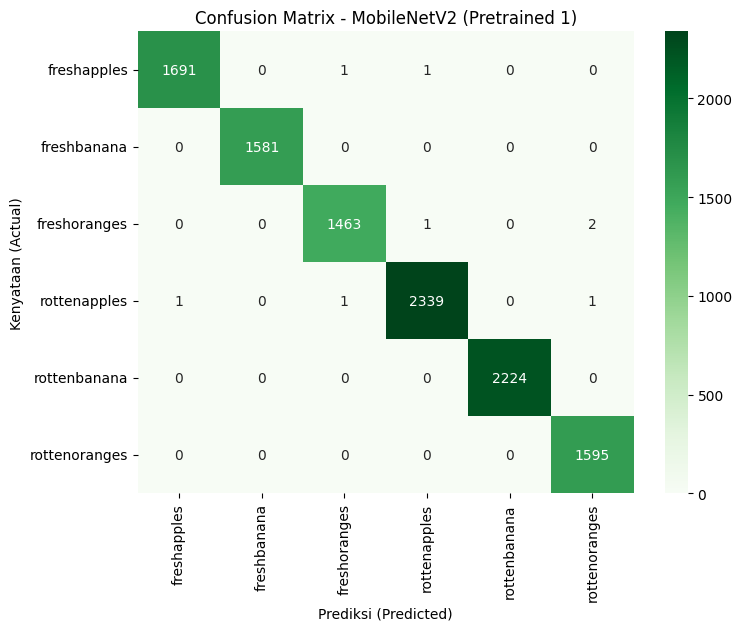


📊 EVALUASI MODEL: VGG16 (Pretrained 2)
10901/10901 ━━━━━━━━━━━━━━━━━━━━ 113s 10ms/step

Classification Report:
               precision    recall  f1-score   support

  freshapples       1.00      1.00      1.00      1693
  freshbanana       1.00      1.00      1.00      1581
 freshoranges       1.00      1.00      1.00      1466
 rottenapples       1.00      0.99      1.00      2342
 rottenbanana       1.00      1.00      1.00      2224
rottenoranges       0.99      1.00      0.99      1595

     accuracy                           1.00     10901
    macro avg       1.00      1.00      1.00     10901
 weighted avg       1.00      1.00      1.00     10901



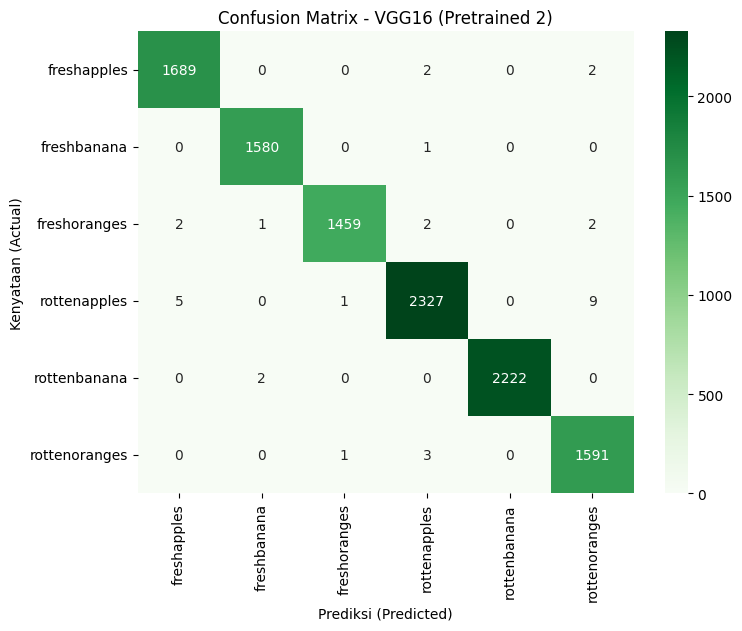

In [ ]:
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# --- 1. SET PATH DATA TEST ANDA ---
# Ganti 'data_test' dengan nama folder test Anda yang sebenarnya
test_dir = '/content/drive/MyDrive/UAP ML/Dataset UAP'

# Cek apakah folder ada sebelum lanjut
if not os.path.exists(test_dir):
    print(f"❌ ERROR: Folder '{test_dir}' tidak ditemukan!")
    print("Silakan pastikan nama folder sudah benar dan berada di direktori yang sama.")
else:
    # --- 2. SETUP GENERATOR UNTUK DATA TEST ---
    # Menggunakan target_size (150,150) sesuai pelatihan model sebelumnya [cite: 39]
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical',
        shuffle=False # Wajib False agar hasil Confusion Matrix akurat
    )

    # --- 3. FUNGSI EVALUASI OTOMATIS ---
    def evaluate_model(model, name):
        print(f"\n" + "="*30)
        print(f"📊 EVALUASI MODEL: {name}")
        print("="*30)

        # Prediksi
        test_generator.reset()
        y_pred = model.predict(test_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = test_generator.classes
        class_labels = list(test_generator.class_indices.keys())

        # A. Cetak Classification Report [cite: 112]
        # Ini berisi Akurasi, Precision, Recall, dan F1-Score
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred_classes, target_names=class_labels))

        # B. Tampilkan Confusion Matrix [cite: 114]
        cm = confusion_matrix(y_true, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Prediksi (Predicted)')
        plt.ylabel('Kenyataan (Actual)')
        plt.show()

    # --- 4. JALANKAN EVALUASI UNTUK 3 MODEL [cite: 89, 107] ---
    evaluate_model(model_base, "CNN Base (Non-Pretrained)")
    evaluate_model(model_pre1, "MobileNetV2 (Pretrained 1)")
    evaluate_model(model_pre2, "VGG16 (Pretrained 2)")

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 130.3 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np
import os

# --- KONFIGURASI HALAMAN ---
st.set_page_config(page_title="Fruit Quality Classifier", page_icon="🍎", layout="centered")

# --- JUDUL DAN DESKRIPSI ---
st.title("🍎 Klasifikasi Kesegaran Buah")
st.markdown("""
Sistem ini menggunakan **Deep Learning (CNN)** untuk mendeteksi apakah buah (Apel, Pisang, Jeruk) berada dalam kondisi **Segar** atau **Busuk**.
Silakan pilih model dan unggah foto buah untuk memulai.
""")

# --- SIDEBAR: PEMILIHAN MODEL ---
st.sidebar.header("Pengaturan Model")
model_option = st.sidebar.selectbox(
    "Pilih Model untuk Prediksi:",
    ("CNN Base (Non-Pretrained)", "MobileNetV2 (Pretrained)", "VGG16 (Pretrained)")
)

# Mendapatkan path absolut folder saat ini
BASE_DIR = os.path.dirname(os.path.abspath(__file__))

# Fungsi untuk memuat model secara efisien
@st.cache_resource
def load_prediction_model(option):
    # Mapping nama file
    model_files = {
        "CNN Base (Non-Pretrained)": "model_base.h5",
        "MobileNetV2 (Pretrained)": "model_mobilenet.h5",
        "VGG16 (Pretrained)": "model_vgg16.h5"
    }

    file_name = model_files[option]
    # Gabungkan path folder dengan nama file secara absolut
    full_path = os.path.join(BASE_DIR, file_name)

    if os.path.exists(full_path):
        return tf.keras.models.load_model(full_path)
    else:
        return None

# Inisialisasi model
model = load_prediction_model(model_option)

if model is not None:
    st.sidebar.success(f"✅ Model {model_option} berhasil dimuat!")
else:
    st.sidebar.error(f"❌ File {model_option} tidak ditemukan di direktori.")
    st.stop() # Menghentikan aplikasi agar tidak error di bawah

# --- INPUT: UPLOAD GAMBAR ---
uploaded_file = st.file_uploader("Pilih gambar buah...", type=["jpg", "jpeg", "png"])

# Nama kelas sesuai dengan urutan generator saat pelatihan
class_names = ['Fresh Apple', 'Fresh Banana', 'Fresh Orange',
               'Rotten Apple', 'Rotten Banana', 'Rotten Orange']

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Gambar yang Diunggah', use_container_width=True)

    st.write("---")
    st.write("### Hasil Prediksi:")

    if st.button('Klasifikasikan Sekarang'):
        with st.spinner('Sedang memproses...'):
            img = image.resize((150, 150))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            predictions = model.predict(img_array)
            result_index = np.argmax(predictions)
            confidence = 100 * np.max(predictions)

            label = class_names[result_index]

            if "Fresh" in label:
                st.success(f"**HASIL: {label.upper()}**")
            else:
                st.error(f"**HASIL: {label.upper()}**")

            st.write(f"**Tingkat Kepercayaan:** {confidence:.2f}%")

            for i, name in enumerate(class_names):
                st.write(f"{name}")
                st.progress(float(predictions[0][i]))

# --- FOOTER ---
st.write("---")
st.caption("Ujian Akhir Praktikum - Pembelajaran Mesin 2025 | Informatika UMM")

Writing app.py


In [ ]:
!pip install pyngrok -q

In [ ]:
from pyngrok import ngrok

# Membunuh semua sesi yang aktif
ngrok.kill()

In [ ]:
# Pastikan tanda < > dihapus saat memasukkan token
!ngrok config add-authtoken 2yR7qg0rW3d7c2FwEnQFBXQK2n1_2DwaQemQsjhGZP8ehhrHs

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import os

# Jalankan Streamlit di background (pastikan app.py sudah ada)
os.system("nohup streamlit run app.py &")

# Hubungkan kembali
try:
    public_url = ngrok.connect(8501)
    print("Aplikasi Berhasil Terhubung!")
    print("Klik tautan ini:", public_url)
except Exception as e:
    print("Terjadi kesalahan:", e)

Aplikasi Berhasil Terhubung!
Klik tautan ini: NgrokTunnel: "https://af567157bca2.ngrok-free.app" -> "http://localhost:8501"
